In [ ]:
for i in range(100):
	if i % 10 == 0:
		a = 23
	print(f"{i} {a}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 随机种子保证可复现
np.random.seed(42)

def normalize(v):
    return v / (np.linalg.norm(v) + 1e-8)

# 模拟 "真实分布中心" 和 "类别目标"
true_center = np.array([0.0, 0.0])
class_target = np.array([2.0, 2.0])

# 初始点 (噪声)
x0 = np.array([-3.0, -2.5])

# 步数
steps = 15
lr = 0.3  # 步长
guidance_scale = 1.5  # 引导强度

# 保存轨迹
traj_plain = [x0.copy()]
traj_classifier = [x0.copy()]
traj_cfg = [x0.copy()]

x_plain = x0.copy()
x_cls = x0.copy()
x_cfg = x0.copy()

for t in range(steps):
    # 普通去噪方向: 朝向真实分布中心
    grad_data = normalize(true_center - x_plain)
    
    # 分类器梯度方向: 朝向类别目标
    grad_cls = normalize(class_target - x_cls)
    
    # CFG近似: cond - uncond
    grad_cfg_uncond = normalize(true_center - x_cfg)
    grad_cfg_cond   = normalize(class_target - x_cfg)
    grad_cfg = grad_cfg_uncond + guidance_scale * (grad_cfg_cond - grad_cfg_uncond)

    # 更新
    x_plain += lr * grad_data
    x_cls += lr * (grad_data + guidance_scale * grad_cls)
    x_cfg += lr * grad_cfg

    traj_plain.append(x_plain.copy())
    traj_classifier.append(x_cls.copy())
    traj_cfg.append(x_cfg.copy())

traj_plain = np.array(traj_plain)
traj_classifier = np.array(traj_classifier)
traj_cfg = np.array(traj_cfg)

# ============ 绘图 ============
plt.figure(figsize=(6,6))

# 分布中心和类别目标
plt.scatter(*true_center, c="black", marker="x", s=100, label="真实分布中心")
plt.scatter(*class_target, c="red", marker="*", s=150, label="类别目标")

# 三条轨迹
plt.plot(traj_plain[:,0], traj_plain[:,1], "b-o", label="无引导")
plt.plot(traj_classifier[:,0], traj_classifier[:,1], "g-o", label="Classifier Guidance")
plt.plot(traj_cfg[:,0], traj_cfg[:,1], "m-o", label="Classifier-Free Guidance")

plt.legend()
plt.title("Diffusion Guidance 可视化 (toy example)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.axis("equal")
plt.show()


In [ ]:
import math

math.pow(0.999, 20)

In [ ]:
import math
math.sqrt(7)

In [ ]:
import torch, math, random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------ 1. 目标分布：双峰 ------------------
d = 2                          # 数据维度
modes = torch.tensor([[-4., 0.],
                      [ 4., 0.]], device=device)  # 两个模态坐标

def sample_target(batch):
    """从目标分布采样 y。这里是两个 Dirac 点，也可加小噪声形成高斯."""
    idx = torch.randint(0, 2, (batch,), device=device)
    return modes[idx] + torch.randn_like(modes[idx]) * 0.1  # 加点噪声，形成高斯

# ------------------ 2. 向量场网络 v_θ(x, t) ------------------
class VecField(nn.Module):
    def __init__(self, hidden=128, layers=4):
        super().__init__()
        # 输入 = x (d) + t (1)
        dims = [d + 1] + [hidden] * (layers - 1) + [d]
        self.fcs = nn.ModuleList(
            nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=-1)          # (B, d+1)
        h = xt
        for fc in self.fcs[:-1]:
            h = F.gelu(fc(h))
        return self.fcs[-1](h)                  # (B, d)

model = VecField().to(device)

# ------------------ 3. Flow-Matching 损失 ------------------
def fm_loss(batch_size):
    # 3.1 采样 (z, y, t)
    z = torch.randn(batch_size, d, device=device)        # prior N(0,I)
    y = sample_target(batch_size)                        # 目标样本
    t = torch.rand(batch_size, 1, device=device)         # U[0,1]

    # 3.2 线性插路径 x_t = (1-t)z + t y
    x_t = (1 - t) * z + t * y

    # 3.3 解析“真”向量场 v* = y - z   (与 t 无关)
    v_star = y - z

    # 3.4 预测向量场
    v_hat = model(x_t, t)

    # 3.5 L2 损失
    return F.mse_loss(v_hat, v_star)

# ------------------ 4. 训练循环 ------------------
opt = Adam(model.parameters(), lr=2e-4)
epochs, steps_per_epoch, bs = 20, 500, 512

for epoch in range(epochs):
    loss_avg = 0.
    for _ in range(steps_per_epoch):
        loss = fm_loss(bs)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_avg += loss.item()
    if (epoch + 1) % 20 == 0:
        print(f"epoch {epoch+1:3d} | loss {loss_avg/steps_per_epoch:.4f}")

# ------------------ 5. 采样函数 (Euler 或 RK4) ------------------
@torch.no_grad()
def sample_from_flow(n_samples=1000, steps=1000, method="euler"):
    x = torch.randn(n_samples, d, device=device)
    dt = 1.0 / steps
    for i in range(steps):
        t = torch.full((n_samples, 1), i * dt, device=device)
        v = model(x, t)
        if method == "euler":
            x = x + v * dt
        elif method == "rk4":                   # 更精确但稍慢
            k1 = v
            k2 = model(x + 0.5 * dt * k1, t + 0.5 * dt)
            k3 = model(x + 0.5 * dt * k2, t + 0.5 * dt)
            k4 = model(x + dt * k3, t + dt)
            x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x.cpu()

# ------------------ 6. 可视化验证 ------------------
samples = sample_from_flow(4000, steps=800, method="rk4")
plt.figure(figsize=(4, 4))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(), c="red", marker="x", s=100)
plt.axis("equal"); plt.title("Flow-matched bimodal samples")
plt.show()


In [ ]:
# ------------------ 5'. 采样并记录轨迹 ------------------
@torch.no_grad()
def sample_trajectory(n_samples=1000,
					  steps=1000,
					  record_frames=10,   # 记录多少张快照
					  method="euler"):
	"""
	返回 list[x_t]，长度 = record_frames + 1。
	x_t[0] 是 t=0 (高斯)，x_t[-1] 是 t=1 (目标)。
	"""
	x = torch.randn(n_samples, d, device=device)
	dt = 1.0 / steps
	xas = x.detach().cpu()  # 初始 x，用于可视化

	# 预先决定需要保存的 step 索引
	save_idx = torch.linspace(0, steps, record_frames + 1, dtype=torch.long)
	frames = []

	for i in range(steps + 1):
		if i in save_idx:               # 保存当前 x
			frames.append(x.detach().cpu())
		if i == steps:                  # 已到 t=1，结束
			break

		t = torch.full((n_samples, 1), i * dt, device=device)
		v = model(x, t)

		if method == "euler":
			x = x + v * dt
		else:                           # RK4
			k1 = v
			k2 = model(x + 0.5 * dt * k1, t + 0.5 * dt)
			k3 = model(x + 0.5 * dt * k2, t + 0.5 * dt)
			k4 = model(x + dt * k3,      t + dt)
			x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
	xbs = x.detach().cpu()  # 最终 x，用于可视化

	return frames, xas, xbs            # list[Tensor]，每个 (B, d)
# ------------------ 6'. 可视化演进 ------------------
frames, xas, xbs = sample_trajectory(n_samples=10,
						   steps=10,
						   record_frames=8,
						   method="rk4")

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for k, (ax, pts) in enumerate(zip(axes, frames)):
	ax.scatter(pts[:, 0], pts[:, 1], s=4, alpha=0.4)
	ax.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(),
			   c="red", marker="x", s=80, linewidths=2)
	ax.set_title(f"t = {k / (len(frames)-1):.2f}")
	ax.set_xlim(-8, 8); ax.set_ylim(-5, 5)
	ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")

fig.suptitle("Flow Matching: Gaussian → Bimodal Trajectory", fontsize=16)
plt.tight_layout()
plt.show()

print(f"xas: {xas}, \n xbs: {xbs}\n")


In [ ]:
# ------------------ 5''  逆向采样并记录轨迹 ------------------
@torch.no_grad()
def sample_trajectory_reverse(n_samples=1000,
							  steps=1000,
							  record_frames=10,
							  method="euler"):
	"""
	从目标分布出发，沿  -v_θ  积分，把样本推回高斯。
	返回 list[x_t]，长度 = record_frames + 1，x_t[0] 对应 t=1。
	"""
	# x = sample_target(n_samples)                   # 初始 t=1
	
	x = xbs.to(device)  # 从之前的 xbs 开始
	xbs_copy = x
	dt = 1.0 / steps
	save_idx = torch.linspace(0, steps, record_frames + 1,
							  dtype=torch.long)
	frames = []

	for i in range(steps + 1):
		if i in save_idx:
			frames.append(x.detach().cpu())
		if i == steps:
			break

		t = torch.full((n_samples, 1),
					   1.0 - i * dt,              # 当前时间
					   device=device)
		v = model(x, t)

		if method == "euler":
			x = x - v * dt                       # 负向量场
		else:                                    # RK4，负 dt
			k1 = -v
			k2 = -(model(x + 0.5 * dt * k1, t - 0.5 * dt))
			k3 = -(model(x + 0.5 * dt * k2, t - 0.5 * dt))
			k4 = -(model(x + dt * k3,       t - dt))
			x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

	xcs = x.detach().cpu()  # 最终 x，用于可视化
	return frames, xbs_copy, xcs        # list[Tensor]，每个 (B, d)
# ------------------ 6''  逆向可视化 ------------------
frames_rev, xbs_copy, xcs = sample_trajectory_reverse(n_samples=10,
									   steps=10,
									   record_frames=8,
									   method="rk4")

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for k, (ax, pts) in enumerate(zip(axes, frames_rev)):
	ax.scatter(pts[:, 0], pts[:, 1], s=4, alpha=0.4)
	ax.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(),
			   c="red", marker="x", s=80, linewidths=2)
	ax.set_title(f"t = {1 - k / (len(frames_rev)-1):.2f}")
	ax.set_xlim(-8, 8); ax.set_ylim(-5, 5)
	ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")

fig.suptitle("Reverse Flow: Bimodal → Gaussian Trajectory", fontsize=16)
plt.tight_layout()
plt.show()

torch.set_printoptions(precision=10)

# 示例打印
print(f", \n xbs: {xbs}\n xbs_copy: {xbs_copy}")
print(f"xas: {xas}, \n xcs: {xcs}\n")

diff = xcs - xas
diff_std = diff.std(unbiased=False)  # 如果你想除以 N，不加的话是除以 N-1
diff_mean = diff.mean()

print(f"diff std: {diff_std:.10f}")
print(f"diff mean: {diff_mean:.10f}")
print(f"diff abs mean: {diff.abs().mean():.10f}")
print(f"diff max: {diff.abs().max():.10f}")

In [ ]:
# ------------------ 5''  逆向采样并记录轨迹 ------------------
@torch.no_grad()
def sample_trajectory_reverse(n_samples=1000,
                              steps=1000,
                              record_frames=10,
                              method="euler"):
    """
    从目标分布出发，沿  -v_θ  积分，把样本推回高斯。
    返回 list[x_t]，长度 = record_frames + 1，x_t[0] 对应 t=1。
    """
    x = sample_target(n_samples)                   # 初始 t=1
    x = x + torch.randn_like(x) * 0.01  # 加点噪声，形成高斯
    dt = 1.0 / steps
    save_idx = torch.linspace(0, steps, record_frames + 1,
                              dtype=torch.long)
    frames = []

    for i in range(steps + 1):
        if i in save_idx:
            frames.append(x.detach().cpu())
        if i == steps:
            break

        t = torch.full((n_samples, 1),
                       1.0 - i * dt,              # 当前时间
                       device=device)
        v = model(x, t)

        if method == "euler":
            x = x - v * dt                       # 负向量场
        else:                                    # RK4，负 dt
            k1 = -v
            k2 = -(model(x + 0.5 * dt * k1, t - 0.5 * dt))
            k3 = -(model(x + 0.5 * dt * k2, t - 0.5 * dt))
            k4 = -(model(x + dt * k3,       t - dt))
            x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return frames        # list[Tensor]，每个 (B, d)
# ------------------ 6''  逆向可视化 ------------------
frames_rev = sample_trajectory_reverse(n_samples=4000,
                                       steps=800,
                                       record_frames=8,
                                       method="rk4")

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for k, (ax, pts) in enumerate(zip(axes, frames_rev)):
    ax.scatter(pts[:, 0], pts[:, 1], s=4, alpha=0.4)
    ax.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(),
               c="red", marker="x", s=80, linewidths=2)
    ax.set_title(f"t = {1 - k / (len(frames_rev)-1):.2f}")
    ax.set_xlim(-8, 8); ax.set_ylim(-5, 5)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")

fig.suptitle("Reverse Flow: Bimodal → Gaussian Trajectory", fontsize=16)
plt.tight_layout()
plt.show()


In [2]:
import h5py
import json
import pprint
from deepdiff import DeepDiff  # pip install deepdiff
import os
files = [
    "demo_v141.hdf5",
    "image.hdf5",
    "low_dim_v141.hdf5",
]

env_args_list = {}

for fname in files:
    with h5py.File(os.path.join('/mnt/ssd0/data/robomimic/robomimic_official/can/ph/',fname), "r") as f:
        env_meta = json.loads(f["data"].attrs["env_args"])
        env_args_list[fname] = env_meta
        print(f"===== {fname} =====")
        pprint.pprint(env_meta)
        print()

# 两两对比
print("===== Differences =====")
for i in range(len(files)):
    for j in range(i + 1, len(files)):
        f1, f2 = files[i], files[j]
        diff = DeepDiff(env_args_list[f1], env_args_list[f2], ignore_order=True)
        print(f"\n--- {f1} vs {f2} ---")
        if diff:
            print(diff)
        else:
            print("No difference.")


===== demo_v141.hdf5 =====
{'env_kwargs': {'camera_depths': False,
                'camera_heights': 84,
                'camera_names': 'agentview',
                'camera_widths': 84,
                'control_freq': 20,
                'controller_configs': {'control_delta': True,
                                       'damping': 1,
                                       'damping_limits': [0, 10],
                                       'impedance_mode': 'fixed',
                                       'input_max': 1,
                                       'input_min': -1,
                                       'interpolation': None,
                                       'kp': 150,
                                       'kp_limits': [0, 300],
                                       'orientation_limits': None,
                                       'output_max': [0.05,
                                                      0.05,
                                                      0.05

In [3]:
import h5py, json
import os


src = os.path.join('/mnt/ssd0/data/robomimic/robomimic_official/can/ph/',"image.hdf5")
dst = "image_env_only.hdf5"

with h5py.File(src, "r") as fsrc, h5py.File(dst, "w") as fdst:
    # 建一个空 group
    g = fdst.create_group("data")
    # 复制 env_args 属性
    g.attrs["env_args"] = fsrc["data"].attrs["env_args"]

print(f"已生成 {dst}")


已生成 image_env_only.hdf5


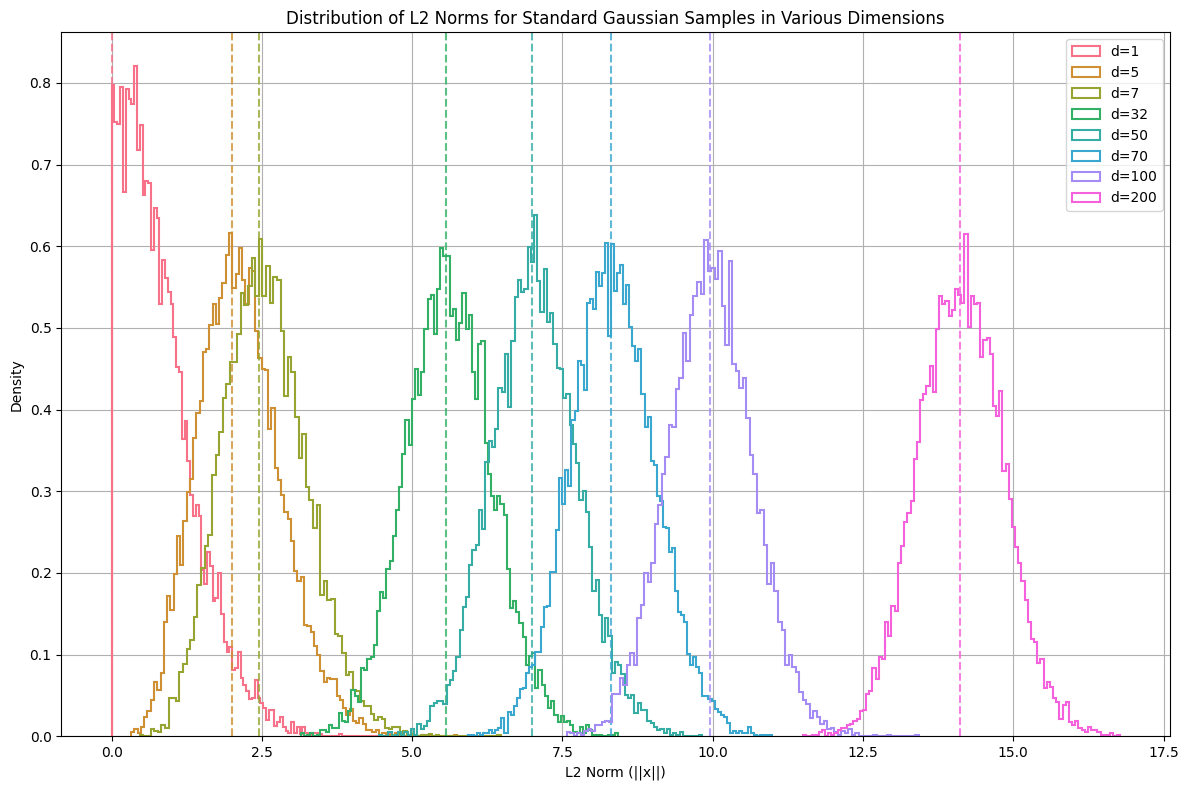

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置不同维度
dims = [1, 5, 7, 32, 50, 70, 100, 200]
num_samples = 10000

# 设置图像
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(dims))

# 对每个维度采样并计算 L2 范数
for i, d in enumerate(dims):
    samples = np.random.randn(num_samples, d)
    norms = np.linalg.norm(samples, axis=1)
    plt.hist(norms, bins=100, density=True, histtype='step',
             label=f'd={d}', color=colors[i], linewidth=1.5)
    
    # 添加 sqrt(d) 的竖线
    plt.axvline(np.sqrt(d-1), color=colors[i], linestyle='--', alpha=0.8)

plt.title("Distribution of L2 Norms for Standard Gaussian Samples in Various Dimensions")
plt.xlabel("L2 Norm (||x||)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()